In [36]:
import os, sys
import gc

import matplotlib.pylab as plt
%pylab inline

import pandas as pd

from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from scipy import ndimage as ndi

IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
IMAGE_DIM = 3

Populating the interactive namespace from numpy and matplotlib


C:\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt', 'resize', 'imshow', 'imread']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
X_train = np.load("X_train.npy")
y_train = np.load("y_train.npy")
X_test = np.load("X_test.npy")

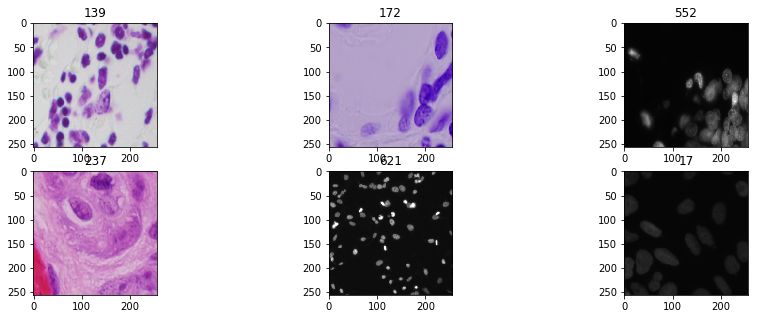

In [20]:

plt.figure(figsize=(15,5))
for i in range(6):
    rnd = np.random.randint(len(X_train))
    plt.subplot(2,3,i+1)
    plt.title(rnd)
    plt.imshow(X_train[rnd])

### In the visualization above we can see that there are different staining methods for nuclei detection. In a first attempt we will try to process all images the same. Even though it might be worthwile to filter the images based on their staining method. *(Fluorescence images might be easier to segment via computer vision)*

# 1. Convert all images in greyscale

# 2. Lets try all skimage thresholds on the grayscale images before augmentation

# Different image classes 

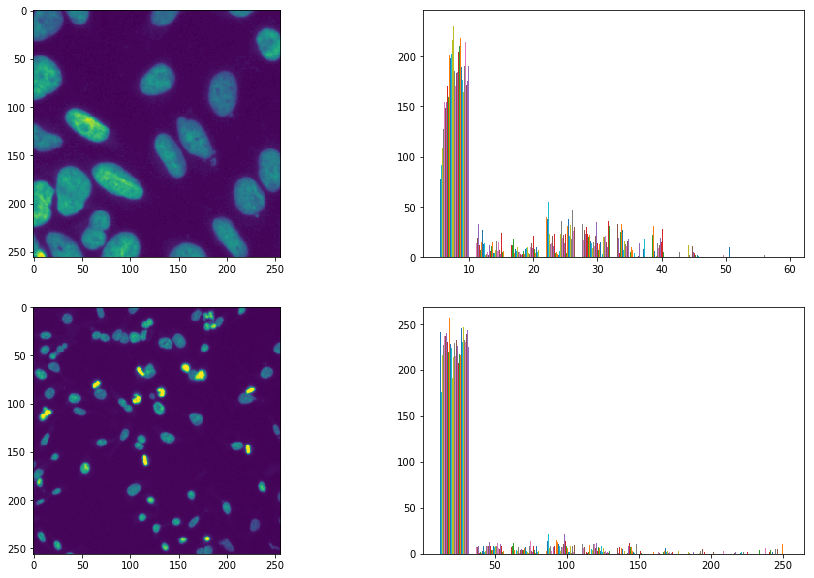

In [78]:
plt.figure(figsize=(15,10))
plt.subplot(221)
plt.imshow(X_train_gray[17]);
plt.subplot(222)
plt.hist(X_train_gray[17], bins=10);
plt.subplot(223)
plt.imshow(X_train_gray[621]);
plt.subplot(224)
plt.hist(X_train_gray[621], bins=10);

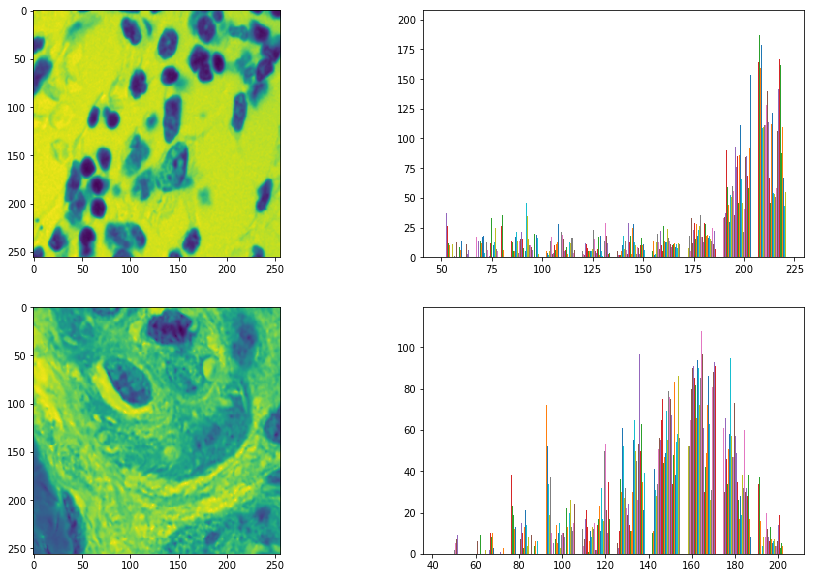

In [79]:
plt.figure(figsize=(15,10))
plt.subplot(221)
plt.imshow(X_train_gray[139]);
plt.subplot(222)
plt.hist(X_train_gray[139], bins=10);
plt.subplot(223)
plt.imshow(X_train_gray[237]);
plt.subplot(224)
plt.hist(X_train_gray[237], bins=10);

# Lets first try a watershed segmentation, kind of an edge based segmentation

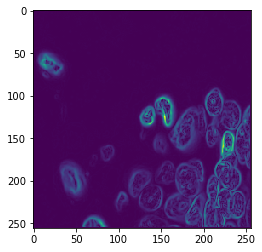

In [118]:
IOI = 552

markers = np.zeros_like(X_train_gray[IOI])
markers[X_train_gray[IOI] < 25] = 1
markers[X_train_gray[IOI] > 25] = 2

from skimage.filters import sobel
elevation_map = sobel(X_train_gray[IOI])
plt.imshow(elevation_map)

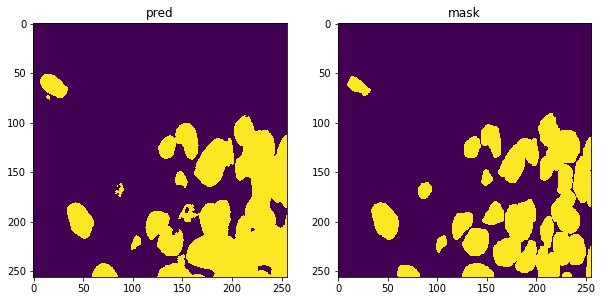

In [119]:
from skimage.morphology import watershed
segmentation = watershed(elevation_map, markers)
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.title("pred")
plt.imshow(segmentation)
plt.subplot(122)
plt.title("mask")
plt.imshow(np.squeeze(y_train[IOI]))

### Seems to work alright for some pictures. However, one big problem here is that the markers have to be set correctly which, at least for the unaugmented images, has to be done individually. 

# Next, thresholding. The background seems to be relatively even in the fluorescence images and thresholding might be the way to go. For the histological images we have to probably come up with something different

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


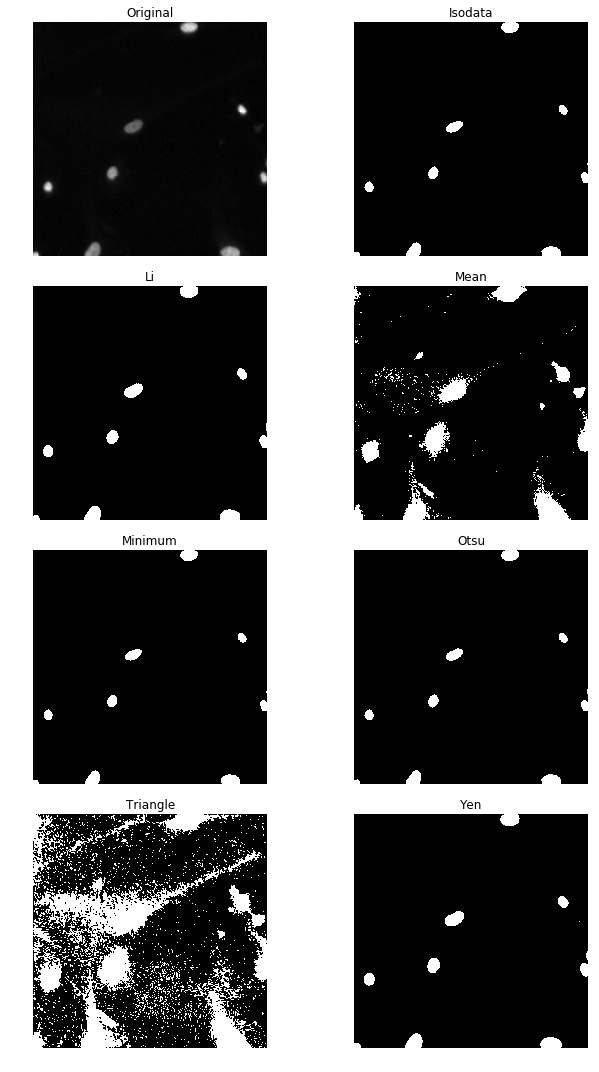

In [207]:
# from skimage.filters import try_all_threshold

fig, ax = try_all_threshold(X_test_gray[47], figsize=(10,15));

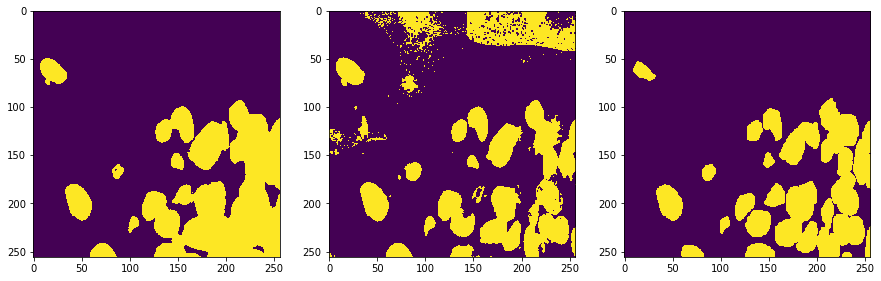

In [160]:
from skimage.filters import threshold_mean, threshold_local

global_thresh = threshold_mean(X_train_gray[IOI])
binary_global = X_train_gray[IOI] > global_thresh

block_size = 141
adaptive_thresh = threshold_local(X_train_gray[IOI], block_size, offset=0)
binary_adaptive = X_train_gray[IOI] > adaptive_thresh


plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(binary_global)
plt.subplot(132)
plt.imshow(binary_adaptive)
plt.subplot(133)
plt.imshow(np.squeeze(y_train[IOI]))

### Global thresholding based on mean seems to yield quite satisfying results. Only problem is that for histo stainings the threshold is inversed. The ROIs are darker than the background wheras in fluorescence the ROI is lighter than the background.

### Lets take a look if we can seperate those two kinds of plots somehow and invert one of them

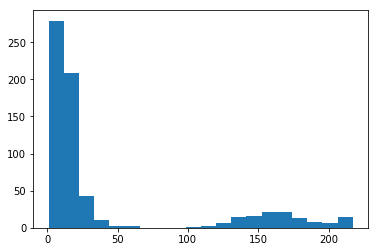

In [168]:
means = [np.mean(i) for i in X_train_gray]
plt.hist(means, bins=20);

histos = [X_train_gray[i] for i in range(len(X_train_gray)) if means[i] > 75]

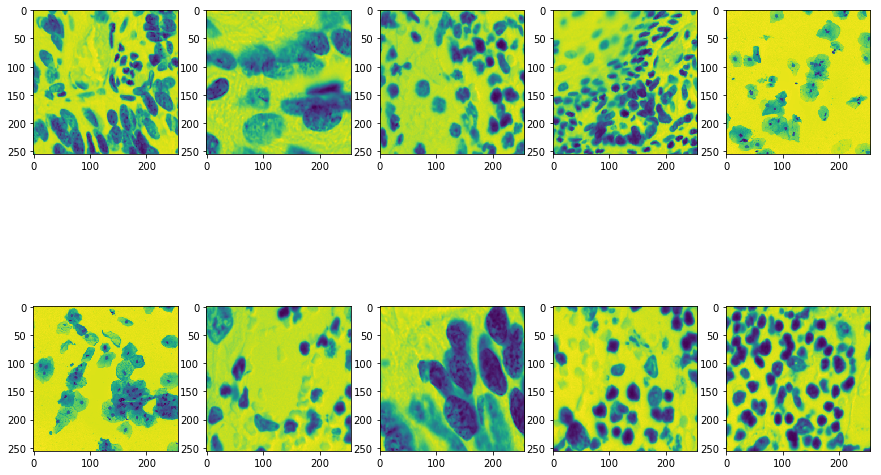

In [169]:
plt.figure(figsize=(15,10))
for i in range(10):
    rnd = np.random.randint(len(histos))
    plt.subplot(2,5,i+1)
    plt.imshow(histos[rnd])

In [173]:
root = ".\Input\stage1_test"
dirlist = [ item for item in os.listdir(root) if os.path.isdir(os.path.join(root, item)) ]

X_test = np.zeros((len(dirlist), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DIM), dtype=np.uint8)
sizes_test = []
test_ids = []
print('Getting and resizing test images ... ')
for i in tnrange(len(dirlist)):
    test_ids.append(dirlist[i])
    image_root = "{}\{}\images\{}.png".format(root, dirlist[i], dirlist[i])
    img = imread(image_root)[:,:,:IMAGE_DIM]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH), mode='constant', preserve_range=True)
    X_test[i] = img

AttributeError: 'list' object has no attribute 'dtype'

## Ok so at this point we have a rudimentary machinery for nucleus segmentation which can be applied for the test set. However lets define some functions in order to process all the images
<ol>
    <li>
        <p>Convert to grayscale</p>
    </li>
    <li>
        <p>Invert histo images</p>
    </li>
    <li>
        <p>Threshold using mean threshold *Can try different thresholds later*</p>
    </li>
</ol>

In [212]:
def rgb2gray(rgb):
    """
    input:  rgb image
    return: grayscale image
    """
    return np.dot(rgb[:,:,:3], [0.299, 0.587, 0.114])


def invert_histos(img):
    """
    input: (grayscale) image
    Function checks if image has light or dark background
    If image has light background image is inverted 
    return: image with light background
    """
    from skimage.util import invert
    desc_bound = 75
    if np.mean(img) > desc_bound:
        img = invert(img)
    
    return img
    

def thresholding(img):
    """
    input: image
    use of mean thresholding on image
    return: binary mask 
    """
    from skimage.filters import threshold_mean, threshold_otsu
    global_thresh = threshold_otsu(img)
    binary_global = img > global_thresh
    
    return binary_global 

    
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths


def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [213]:
from skimage.io import imread, imread_collection
from tqdm import tnrange, tqdm_notebook

root = ".\Input\stage1_test"
dirlist = [ item for item in os.listdir(root) if os.path.isdir(os.path.join(root, item)) ]

masks = []
test_ids = []
print('Computer vision based mask generation ... ')
for i in tnrange(len(dirlist)):
    test_ids.append(dirlist[i])
    img_root = "{}\{}\images\{}.png".format(root, dirlist[i], dirlist[i])
    img = imread(img_root)
    img = rgb2gray(img)
    img = invert_histos(img)
    masks.append(thresholding(img))

Computer vision based mask generation ... 


In [216]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(masks[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

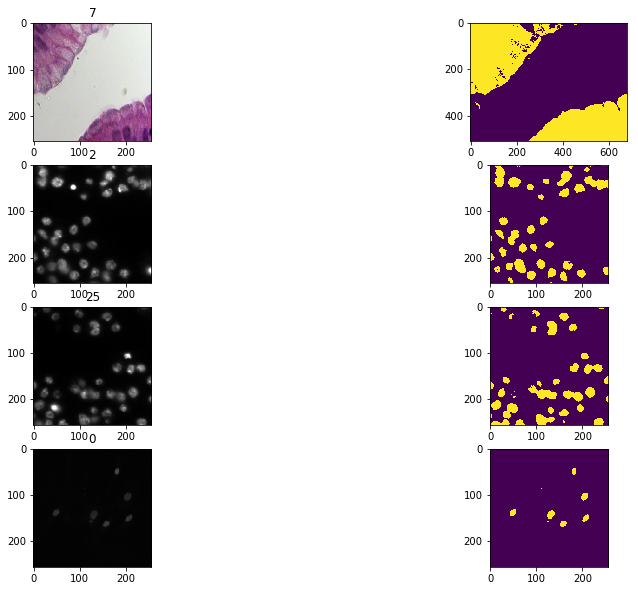

In [215]:
plt.figure(figsize=(15,10))
for i in range(4):
    ax = plt.subplot2grid((4,2),(i,0))
    rnd = random.randint(len(masks))
    plt.title(rnd)
    plt.imshow(X_test[rnd])
    ax = plt.subplot2grid((4,2),(i,1))
    plt.imshow(np.squeeze(masks[rnd]))

    

In [217]:
# Create submission DataFrame
import datetime

sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
now = datetime.datetime.now()
sub.to_csv('computervision_{}.csv'.format(now.strftime("%d-%m-%H-%M")), index=False)